In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [4]:
DF = pd.read_excel('PQM dataset.xlsx', sheet_name='RMS_10Min')
print("DataFrame shape:", DF.shape)
# taking only first 13 columns as instructed
DF_first13 = DF.iloc[:,:13]
print("First 13 columns DataFrame shape:", DF_first13.shape)
trunc_row = 36033
DF_truncated = DF_first13.iloc[:trunc_row]
print("Truncated DataFrame shape:", DF_truncated.shape)

DataFrame shape: (360300, 73)
First 13 columns DataFrame shape: (360300, 13)
Truncated DataFrame shape: (36033, 13)


In [5]:
# calculating z-scores for outlier detection
def calc_zscore(column):
    mean = np.mean(column)
    std_dev = np.std(column)

    if std_dev == 0:
        return np.zeros_like(column)
    
    z_scores = (column - mean) / std_dev
    return z_scores

In [ ]:
columns = [col for col in DF_first13.columns if col not in ['TimeID']]

z_scores = DF_first13[columns].apply(calc_zscore)

print(z_scores.head())

      Col_1     Col_2     Col_3     Col_4     Col_5     Col_6     Col_7  \
0 -3.841262 -3.840779 -3.840984 -6.035013 -6.032716 -6.035425 -6.041177   
1 -3.841367 -3.840733 -3.840915 -6.033181 -6.032716 -6.033359 -6.041407   
2 -3.841236 -3.840898 -3.840710 -6.034155 -6.032716 -6.033359 -6.041695   
3 -3.841375 -3.840804 -3.841030 -6.032945 -6.030646 -6.033359 -6.041297   
4 -3.841038 -3.840372 -3.840915 -6.032945 -6.030646 -6.033359 -6.040650   

      Col_8     Col_9    Col_10    Col_11    Col_12  
0 -6.041461 -6.036593 -3.839980 -3.840543 -3.840426  
1 -6.041461 -6.037369 -3.840251 -3.840052 -3.840532  
2 -6.040568 -6.036344 -3.840202 -3.839561 -3.840401  
3 -6.041461 -6.038184 -3.839859 -3.840525 -3.840539  
4 -6.042443 -6.036593 -3.839623 -3.839644 -3.840201  


In [7]:
# cleaning data by removing outliers and filling NaN values
outlier_mask = (np.abs(z_scores) > 3).any(axis=1)
print(f"Found {outlier_mask.sum()} outliers in the dataset")

cleanDF = DF_first13 #[~outlier_mask]
cleanDF = cleanDF.fillna(cleanDF.mean())
print("Cleaned DataFrame shape:", cleanDF.shape)

Found 22527 outliers in the dataset
Cleaned DataFrame shape: (360300, 13)


In [8]:
# window size = 6 for 12 columns
input_size = 6
power_columns = [col for col in cleanDF.columns if col != 'TimeID']

x_list = []
y_list = []

In [9]:
for i in range(len(power_columns) - input_size):
    input_window = power_columns[i:i + input_size]
    target_column = power_columns[i + input_size]

    x_list.append(cleanDF[input_window].values)
    y_list.append(cleanDF[target_column].values)

In [10]:
x = np.vstack(x_list)
y = np.hstack(y_list)

print("Input shape:", x.shape)
print("Target shape:", y.shape)

Input shape: (2161800, 6)
Target shape: (2161800,)


In [11]:
split_index = int(0.8 * len(x))

x_train = x[:split_index]
y_train = y[:split_index]

x_test = x[split_index:]
y_test = y[split_index:]

print("Training set shape:", x_train.shape, y_train.shape)
print("Test set shape:", x_test.shape, y_test.shape)

Training set shape: (1729440, 6) (1729440,)
Test set shape: (432360, 6) (432360,)


In [12]:
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(x_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
# test train split
y_pred = model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance on Test Set:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Model Performance on Test Set:
Mean Absolute Error (MAE): 196.4935
Mean Squared Error (MSE): 1117811.8453
R-squared (R2): 0.9963


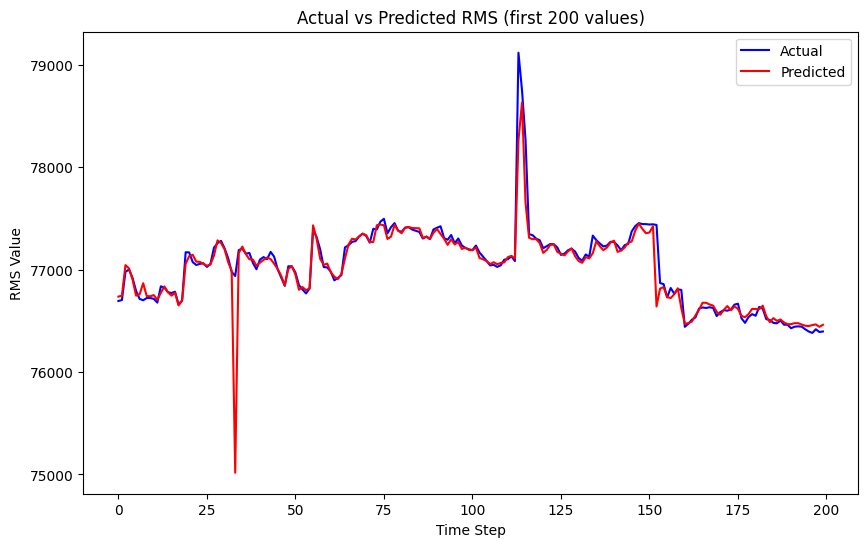

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(y_test[:200], label='Actual', color='blue')
plt.plot(y_pred[:200], label='Predicted', color='red')
plt.title('Actual vs Predicted RMS (first 200 values)')
plt.xlabel('Time Step')
plt.ylabel('RMS Value')
plt.legend()
plt.show()

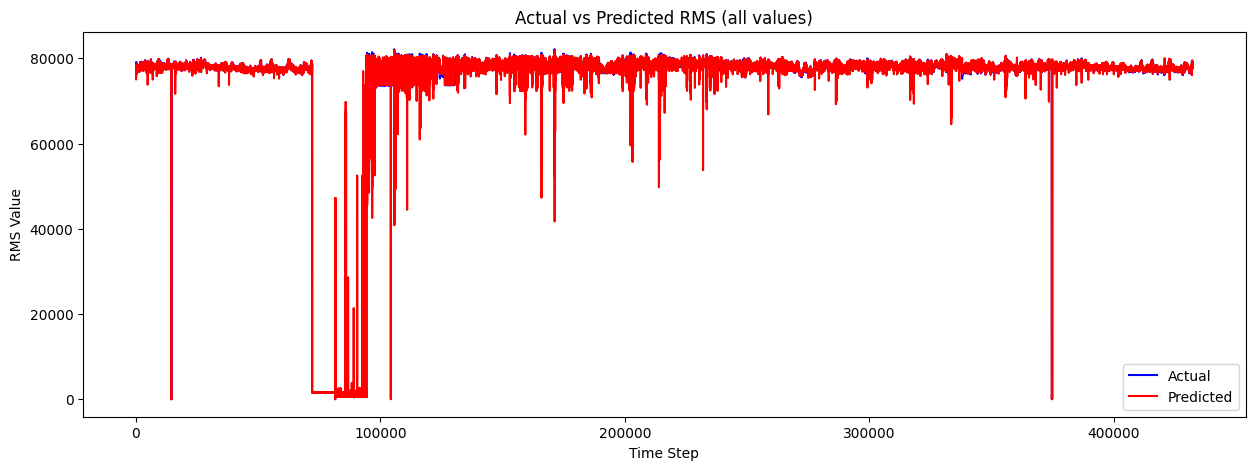

In [15]:
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted RMS (all values)')
plt.xlabel('Time Step')
plt.ylabel('RMS Value')
plt.legend()
plt.show()